## --The Start--

###### Anaconda3/.../bin에 ipopt.exe 파일 있어야 계산됨.

## Unit Commitment

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image

import shutil
import sys
import os.path

import pyomo.gdp as gdp
import pyomo.environ as pyo
from pyomo.opt.base.solvers import *

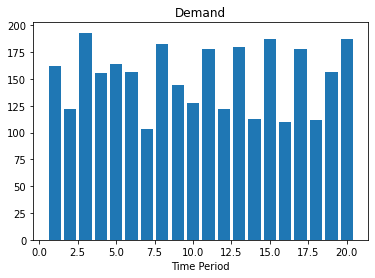

In [27]:
# demand
T = 20
T = np.array([t for t in range(0, T)])
d = np.array([100 + 100*np.random.uniform() for t in T])

fig, ax = plt.subplots(1,1)
ax.bar(T+1, d)
ax.set_xlabel('Time Period')
ax.set_title('Demand')
plt.show()

In [28]:
print(d.shape)
print(d)

(20,)
[162.41799634 121.60185735 193.22383731 155.88518424 163.85309235
 156.28801792 103.30658213 182.38896287 144.4015293  127.8872193
 177.63956494 121.6579089  179.65875091 112.34695664 187.20160419
 109.95116896 178.34082959 112.2167236  157.02952977 187.22028289]


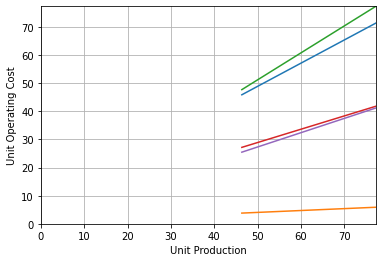

In [29]:
# generating units
N = 5
pmax = 2*max(d)/N
pmin = 0.6*pmax

N = np.array([n for n in range(0, N)])
a = np.array([0.5 + 0.2*np.random.randn() for n in N])
b = np.array([10*np.random.uniform() for n in N])

p = np.linspace(pmin, pmax)

fig, ax = plt.subplots(1,1)
for n in N:
    ax.plot(p, a[n]*p + b[n])
ax.set_xlim(0, pmax)
ax.set_ylim(0, max(a*pmax + b))
ax.set_xlabel('Unit Production')
ax.set_ylabel('Unit Operating Cost')
ax.grid()

#### $$min\sum_{n=N} \sum_{t \in T} (a_n x_{n,t} + b_n u_{n,t})$$
#### $$s.t.\sum_{n \in N} x_{n,t} = d_t$$
#### $$p^{min}_n u_{n,t} \le  x_{n,t}$$
#### $$p^{max}_n u_{n,t} \ge  x_{n,t}$$

In [30]:
def unit_commitment():
    m = pyo.ConcreteModel() # m은 model을 말함

    m.N = pyo.Set(initialize=N)
    m.T = pyo.Set(initialize=T)

    # m.N과 m.T로 인덱싱 되고 있음.
    m.x = pyo.Var(m.N, m.T, bounds=(0, pmax)) # 발전량에 대한 제약조건 포함. -----> 발전량
    m.u = pyo.Var(m.N, m.T, domain=pyo.Binary) # 이 변수는 {0, 1}에 속함. ----> on/off

    # Objective Function
    # 두 개의 summation이 이중 for loop으로 표현됨.
    m.cost = pyo.Objective(expr=sum(m.x[n,t]*a[n] + m.u[n,t]*b[n] for t in m.T for n in m.N))

    # demand
    # demand는 우리가 데이터를 가지고 있음.
    # for all T가 수식에 써있음.
    # 이게 argument m.T로 들어감.
    m.demand = pyo.Constraint(m.T, rule=lambda m, t: sum(m.x[n,t] for n in N) == d[t])

    m.lb = pyo.Constraint(m.N, m.T, rule=lambda m, n, t: pmin*m.u[n,t] <= m.x[n,t])
    m.ub = pyo.Constraint(m.N, m.T, rule=lambda m, n, t: pmax*m.u[n,t] >= m.x[n,t])

    return m

In [31]:
model = unit_commitment()
pyo.SolverFactory('ipopt').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 220
  Number of variables: 200
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.9.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0967400074005127
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


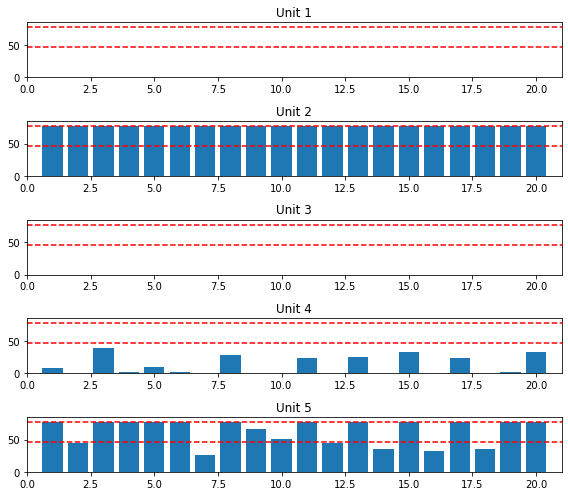

In [34]:
fig, ax = plt.subplots(max(N)+1, 1, figsize=(8, 1.5*max(N)+1))
for n in N:
    ax[n].bar(T+1, [model.x[n,t]() for t in T])
    ax[n].set_xlim(0, max(T)+2)
    ax[n].set_ylim(0, 1.1*pmax)
    ax[n].plot(ax[n].get_xlim(), np.array([pmax, pmax]), 'r--') # 발전 최댓값
    ax[n].plot(ax[n].get_xlim(), np.array([pmin, pmin]), 'r--') # 발전 최솟값
    ax[n].set_title('Unit ' + str(n+1))
fig.tight_layout()

plt.show()

## --The End--